In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# HW2

#### **Задание**: Реализовать взвешенное голосование между градиентным бустингом с логистической функцией потерь, AdaBoost и SVM. Реализацию SVM и AdaBoost взять из sklearn.

In [33]:
import pandas as pd
import numpy as np
from sklearn import cross_validation as cv
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn.cross_validation import KFold
from matplotlib import pyplot as plt

In [7]:
df = pd.read_csv("./spam.train.txt", delim_whitespace=True, header=None)
x_data = df.ix[:, 1:].as_matrix(); y_data = df.ix[:, 0].as_matrix()
y_data[y_data == 0] = -1
x_train, x_test, y_train, y_test = cv.train_test_split(x_data, y_data,
                                                       test_size=0.25, random_state=288)


# CART Implementation 

In [8]:
from src.CART import CART, best_split_mse
from src.model_tree import best_split_mse_brute_force

In [9]:
%timeit CART().fit(x_train, y_train)

1 loops, best of 3: 3.3 s per loop


In [10]:
def run_cv(X, y):
    kf = KFold(len(y), n_folds=3)

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cart = CART()
        cart.fit(X_train, y_train)
        y_pred = cart.predict(X_test)
        print "Cart :", mean_squared_error(y_test, y_pred)
        
        dtr = DecisionTreeRegressor(max_depth=4)
        dtr.fit(X_train, y_train)
        y_pred = dtr.predict(X_test)
        print "SKlearn:", mean_squared_error(y_test, y_pred)
        
run_cv(x_train, y_train)

Cart : 0.339277251539
SKlearn: 0.360369474479
Cart : 0.332214001595
SKlearn: 0.360647878265
Cart : 0.300975971041
SKlearn: 0.356802120599


# GBoost Implementation

In [11]:
from src.GBoost import GBoost

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
gboost = GBoost(10)
gboost.fit(x_train, y_train)

0 1 2 3 4 5 6 7 8 9


In [31]:
gboost.fit(x_train, y_train)

0 1 2 3 4 5 6 7 8 9


In [34]:
pred = gboost.predict(x_test)
f1_score(y_test, pred)

0.95214602861371489

In [32]:
gboost.predict(x_test)

array([-1,  1,  1, ..., -1, -1,  1])

In [35]:
gbc = GradientBoostingClassifier(n_estimators=10, max_depth=4)
gbc.fit(x_train, y_train)
pred = gbc.predict(x_test)
f1_score(y_test, pred)

0.95339805825242718

# Performance Graph

In [16]:
from src.benchmark import draw_graph_hw1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


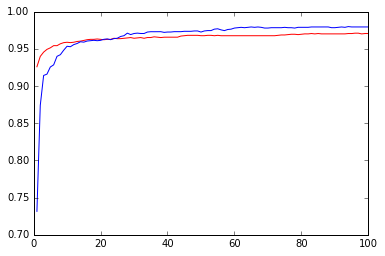

In [37]:
# Tooo long
gboost_scores, sklearn_scores = draw_graph_hw1(x_train, x_test, y_train, y_test, 100)


In [38]:
np.savez("scores100_f1.dat", gboost_scores=gboost_scores, sklearn_scores=sklearn_scores)

In [39]:
scores = np.load('./scores100_f1.dat.npz')

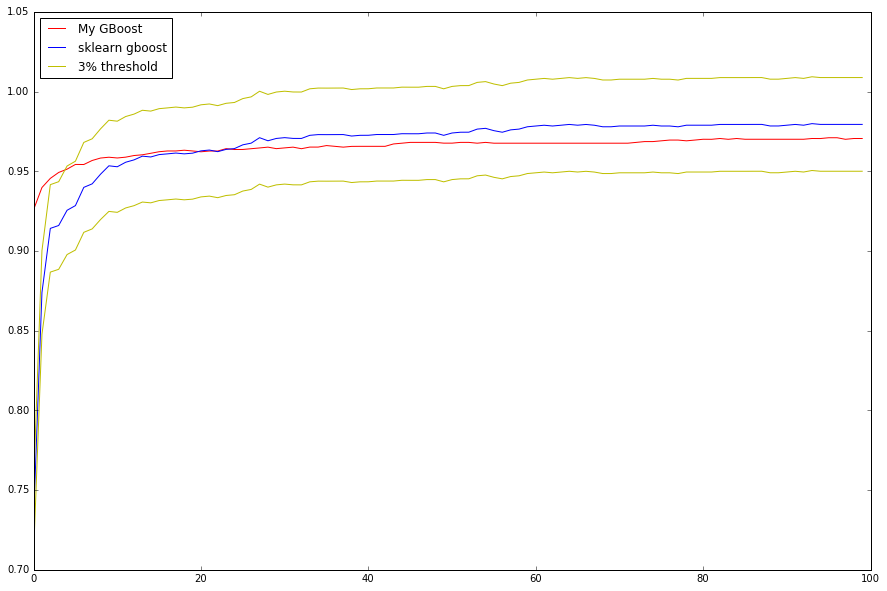

In [47]:
plt.figure(figsize=(15, 10))

plt.plot(range(len(scores["gboost_scores"])), (scores["gboost_scores"]), c="r", label='My GBoost')
plt.plot(range(len(scores["sklearn_scores"])), (scores["sklearn_scores"]), c="b", label='sklearn gboost')
plt.plot(range(len(scores["sklearn_scores"])), (scores["sklearn_scores"])*1.03, c="y", label='3% threshold')
plt.plot(range(len(scores["sklearn_scores"])), (scores["sklearn_scores"])*0.97, c="y")

plt.legend(loc='upper left')

# Weighted Majority

![http://www.kddresearch.org/Courses/Fall-2003/CIS732/Lectures/Lecture-20-20021107.pdf](http://take.ms/HrNMf)

### GBoost

In [48]:
gboost = GBoost(100)
gboost.fit(x_train, y_train)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


In [49]:
y_pred = gboost.predict(x_test)
f1_score(y_test, y_pred)

0.97053045186640463

### AdaBoost

In [52]:
from sklearn.ensemble import AdaBoostClassifier

ada_Boost_clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
ada_Boost_clf.fit(x_train, y_train)
y_pred = ada_Boost_clf.predict(x_test)
f1_score(y_test, y_pred)

0.95656417764763302

### SVM

In [53]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
f1_score(y_test, y_pred)

0.95412844036697242

In [54]:
predictors = [gboost, ada_Boost_clf, svc]

In [55]:
def weighted_majority(predictors, x_train, y_train, betta = 0.65):
    n_samples = x_train.shape[0]
    m_predictors = len(predictors)
    w = np.ones(m_predictors)
    
    prediction = np.zeros((n_samples, m_predictors))
    
    for n in range(n_samples):
        qneg = 0; qpos = 0
        
        for m in range(m_predictors):
            pred = predictors[m].predict([x_train[n,:]])[0]

            qneg += w[m] if pred == -1 else 0
            qpos += w[m] if pred == 1 else 0
            
            if qneg > qpos:
                prediction[n, m] = -1
            elif qneg == qpos:
                prediction[n, m] = 1 if np.random.randint(0,2) else -1
            else:
                prediction[n, m] = 1

            if prediction[n, m] != y_train[n]:
                w[m] *= betta
    return np.array(w)

In [56]:
def weighted_predictor(x, predictors, weights):
    pred = np.array([p.predict(x) for p in predictors])
    pos = np.sum(np.multiply(pred == 1, weights[:, np.newaxis]), axis=0)
    neg = np.sum(np.multiply(pred == -1, weights[:, np.newaxis]), axis=0)
    y_pred = np.argmax(np.vstack((neg, pos)), axis=0)
    y_pred[y_pred == 0] = -1
    return y_pred

In [57]:
weights = weighted_majority(predictors, x_train, y_train)

In [58]:
weights

array([ 1.      ,  0.65    ,  0.274625])

In [59]:
y_pred = weighted_predictor(x_test, predictors, weights)
f1_score(y_test, y_pred)

0.97053045186640463

In [67]:
f_w = np.zeros(x_train.shape[1])

def wide_walk(tree, feature_weigths):
    if tree.split_feature is None:
        return feature_weigths
    
    feature_weigths[tree.split_feature] += tree.score
    
    feature_weigths = wide_walk(tree.fb, feature_weigths)
    feature_weigths = wide_walk(tree.tb, feature_weigths)
    
    return feature_weigths
np.sum(np.array([wide_walk(p.tree, np.zeros(x_train.shape[1])) for p in predictors[0].ensembles]), axis=0)

array([ -0.93167144,  -1.76774211,   0.80308418,   2.39029448,
         1.99632864,   0.6367214 ,   5.53737606,  -0.84847191,
        -1.42840489,   2.238404  ,   4.7883663 ,   1.66166894,
         1.54702573,   5.05257533,   4.58085727,   6.8458436 ,
         6.50156812,   0.91878568,  -0.69997419,   0.52064264,
        -0.43104113,   5.60869662,  -0.36384589,   3.06282199,
         1.2979362 ,  -0.33907877,   0.24065955,  -0.11321198,
         2.33706207,  -0.44923558,  -0.20013917,  -1.46466066,
        -0.23870664,  -1.62774476,   0.12143967,   2.58570947,
         0.        ,   0.70334645,   0.03013795,  -1.23084101,
         1.42278211,  -0.86552376,   1.95736635,   5.92624753,
        -0.4713084 ,   1.23755545,  -0.27510018,   1.1751044 ,
         0.1298106 ,  -1.57178258,   0.0134421 ,   3.50498884,
         4.41674942,   0.23184211,  -0.33355059,   1.81530819,
        11.49964354,   1.46040915,  -0.34268439,   1.31256295,
         0.        ,  -0.05947766,   0.        ,  -0.07

In [ ]:
predictors[0].ensembles[0].tree